In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import numpy.ma as ma
import astropy.io.fits as py
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['font.size'] = 25

In [3]:
def Normalization(data_x, data_y, bins, p_order, fraction, plot, section=0):
    # Input Parameters
    sbin = bins   # of bins used'
    nord = p_order    # order of the curve fitting (>6 is spline)
    frac = fraction # the upper fraction points defined as cont
    #plot = True # plot keyword (1 on, 2 more info,0 off)
    mask = []   # indicies of points to use (or used) in fit'
    bot  = False  # if set then bottom of spectrum is fit
    edit = True   # manuel editing by point (1 on, 0 off)
    temr = 'none' # selects terminal version of point'
    fill_value = 12500.0 # in case of a spline
    
    c = data_x
    s = data_y
    
    
    # Set Parameters
    Len = len(s)
    st = 0
    w = range(Len)
    if plot :
        plt.figure()
        ss = s
        if len(mask) > 0:
            ss = np.ones_like(s)*3*np.max(s)
            ss[mask] = s[mask]
        plt.plot(w, ss)
    mbin = [[] for i in range(sbin)]
    mbw  = [[] for i in range(sbin)]
    mid = 1    # affects how FRAC is interpreted(originally 2)
    
    #Mask out portions of spectrum, if a valid mask was passed or constructed.
    if len(mask) > 1:     # true: valid mask exists
        wsec = w[mask]    # wavelengths of valid continuum points
        ssec = s[mask]    # valid continuum points
    else:
        wsec = w
        ssec = s
        
    Len = len(ssec)
    lb  = Len/sbin


    #***find continuum in each bin
    st = 0
    bpt = lb*(1. - frac/mid)  #is a number
    if bot: bpt=lb*frac/mid
    for nbin in range(sbin):
        nd  = st +lb -1
        wb  = np.array(wsec[int(st):int(nd)])
        Bin = np.array(ssec[int(st):int(nd)])
        Sorted = np.argsort(Bin)  # sort data 
        cnt = Bin[Sorted[int(bpt):].astype(int)]
        cnw = wb[Sorted[int(bpt):].astype(int)]
        st  = nd + 1
        mbin[nbin] = cnt
        mbw[nbin]  = cnw
        if plot:  # remove or comment if the date is too big
            plt.plot(wb, Bin)
            plt.plot(cnw, cnt, '.k')
            
    temp_x = []
    temp_y = []
    for i in range(len(mbw)):
        temp_x.extend(mbw[i])
        temp_y.extend(mbin[i])

    temp_x = np.array(temp_x)
    temp_y = np.array(temp_y)
    mbin  = [x for _, x in sorted(zip(temp_x, temp_y))]
    mbw = sorted(temp_x)

    if plot:
        plt.figure()
        plt.plot(mbw, mbin, 'ko')
        
    #***polynomial or spline fit to continuum
    npl = nord 
    x = mbw 
    y = mbin
    if nord <= 6:
        if nord >= sbin: npl = sbin-1
        nx = len(x)
        mn = np.sum(x)/nx
        x  = x - mn   
        wf = w-mn
        #mn = mean(x)   &   x=x - mn   &   wf=float(w-mn)
        cf = np.polyfit(x,y,npl)     #call poly_fit(intrinsic)
        # be carefull, it returns coeficient in the oposite order.
        c  = np.polyval(cf, wf)      #call poly
        print(cf)
    else:
        wf = w
        print(np.min(x), np.max(x))
        print(np.min(wf), np.max(wf))
        f_interp = interp1d(x, y, bounds_error=False, fill_value=fill_value)
        c = f_interp(wf)
        
    #Plot
    if plot:
        plt.figure()
        plt.plot(w, c, 'k', lw=3)
        plt.plot(w, s, 'C0-')
        plt.plot(mbw,mbin, 'r', alpha=0.5)
        plt.figure()
        plt.plot(w, c, 'k', lw=3)
        plt.plot(mbw,mbin, 'r.', alpha = 0.5)
        plt.figure()
        plt.plot(w, s/c, 'k.')
        plt.plot(w, np.ones(len(w)), '--r', lw=2)
        plt.ylim(0.0,1.2)
    #plt.plot(data_x, s/c, ',')
    #plt.plot(data_x, np.ones(len(w)), '--r', lw=2)
    #plt.text(data_x[0], 0.8, str(section))
    #plt.ylim(0.5,1.2)
    return data_x, s/c

Input

In [4]:
#Inputs:
solar_radius    = 696340              # km
star_radius     = 0.92 *solar_radius
distance_planet = 3.877*star_radius   # a/R* x R*
T_second = 0.7920520*24*60*60         # in second
T = 0.7920520
c = 299792.458                        # km
v = 2*np.pi*distance_planet/T_second  # max velocity # km/s    (58.82 km/s)

time_transit = 50/(24*60)             # 50 minutos to days
transit_time = 2459475.7534475597     # 18 Sept 2021 
 
transit_star = transit_time - time_transit/2
transit_end  = transit_time + time_transit/2

# Load Data

In [5]:
date = "18_Sept_2021"

In [6]:
# Read the files
path = '/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/'
path_out = '/Users/ricardoramirez/Desktop/ReductionESPRESSO/Normalization_'+date+'/'
file_in = [x for x in os.listdir(path)]
file_in.sort()
print(file_in[0])
print(file_in[-1])
file_in = file_in[1:] #Note: not considering README and temporal files, verify all folders are in place
print('---')
print(file_in[0])
print(file_in[-1])
N = len(file_in)
print(N)

.DS_Store
199
---
100
199
100


In [7]:
frame_spec = []
frame_error_spec = []
frame_WL = []

for i in range(N):
    print         (path + str(i+100) + "/cr2res_obs_staring_extracted.fits")
    fits = py.open(path + str(i+100) + "/cr2res_obs_staring_extracted.fits")
    raw_data1 = fits[1].data
    raw_data2 = fits[2].data
    raw_data3 = fits[3].data
    
    spec       = [[] for i in range(21)]
    error_spec = [[] for i in range(21)]
    WL         = [[] for i in range(21)]
    
    for a in range(2048):
        for b in range(6):
            spec[b].        append(raw_data1[a][b*3])
            error_spec[b].  append(raw_data1[a][b*3+1])
            WL[b].          append(raw_data1[a][b*3+2])
        for b in range(6):
            spec[b+6].      append(raw_data2[a][b*3])
            error_spec[b+6].append(raw_data2[a][b*3+1])
            WL[b+6].        append(raw_data2[a][b*3+2])
        for b in range(6):
            try:
                spec[b+12]. append(raw_data3[a][b*3])
            except: break
            error_spec[b+6].append(raw_data3[a][b*3+1])
            WL[b+12].       append(raw_data3[a][b*3+2])
            
    frame_spec.append(spec)
    frame_error_spec.append(error_spec)
    frame_WL.append(WL)

/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/100/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/101/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/102/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/103/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/104/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/105/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/106/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/107/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/108/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/109/cr2res_obs_staring_extracted.fits
/Users/ricardoramire

/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/184/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/185/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/186/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/187/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/188/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/189/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/190/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/191/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/192/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/193/cr2res_obs_staring_extracted.fits
/Users/ricardoramire

Text(0, 0.5, 'ADU')

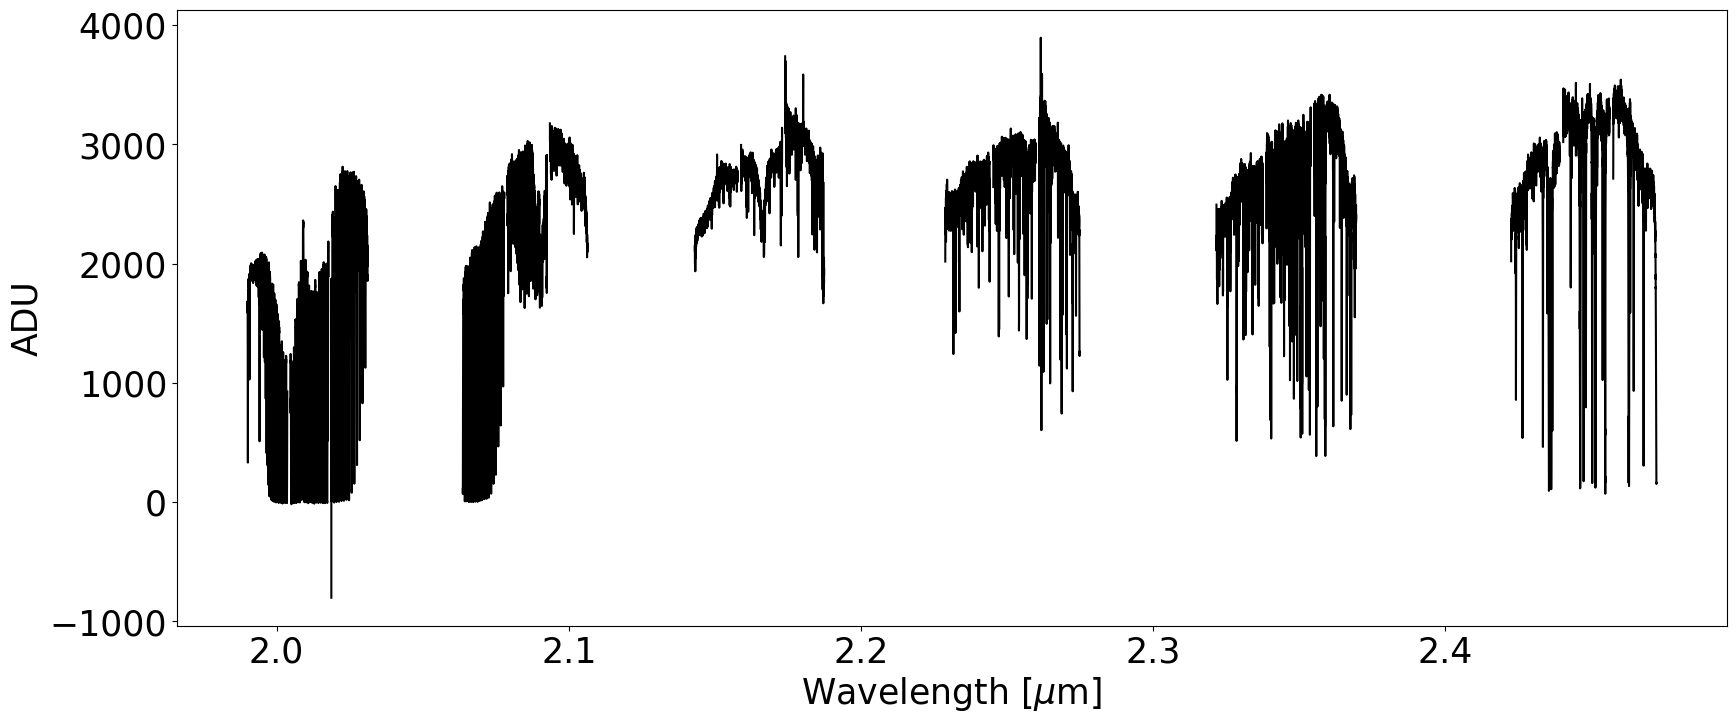

In [19]:
frame = 0


i = 5
plt.plot(np.array(frame_WL[frame][i][4:-4])/1000, frame_spec[frame][i][4:-4], 'k')
i = 11
plt.plot(np.array(frame_WL[frame][i][4:-4])/1000, frame_spec[frame][i][4:-4], 'k')
i = 17
plt.plot(np.array(frame_WL[frame][i][3:-4])/1000, frame_spec[frame][i][3:-4], 'k')

i = 4
plt.plot(np.array(frame_WL[frame][i][4:-4])/1000, frame_spec[frame][i][4:-4], 'k')
i = 10
plt.plot(np.array(frame_WL[frame][i][4:-5])/1000, frame_spec[frame][i][4:-5], 'k')
i = 16
plt.plot(np.array(frame_WL[frame][i][5:-5])/1000, frame_spec[frame][i][5:-5], 'k')

i = 3
plt.plot(np.array(frame_WL[frame][i][5:-5])/1000, frame_spec[frame][i][5:-5], 'k')
i = 9
plt.plot(np.array(frame_WL[frame][i][6:-6])/1000, frame_spec[frame][i][6:-6], 'k')
i = 15
plt.plot(np.array(frame_WL[frame][i][6:-6])/1000, frame_spec[frame][i][6:-6], 'k')

i = 2
plt.plot(np.array(frame_WL[frame][i][7:-7])/1000, frame_spec[frame][i][7:-7], 'k')
i = 8
plt.plot(np.array(frame_WL[frame][i][6:-7])/1000, frame_spec[frame][i][6:-7], 'k')
i = 14
plt.plot(np.array(frame_WL[frame][i][8:-8])/1000, frame_spec[frame][i][8:-8], 'k')

i = 1
plt.plot(np.array(frame_WL[frame][i][7:-8])/1000, frame_spec[frame][i][7:-8], 'k')
i = 7
plt.plot(np.array(frame_WL[frame][i][8:-9])/1000, frame_spec[frame][i][8:-9], 'k')
i = 13
plt.plot(np.array(frame_WL[frame][i][9:-10])/1000, frame_spec[frame][i][9:-10], 'k')

i = 0
plt.plot(np.array(frame_WL[frame][i][9:-10])/1000, frame_spec[frame][i][9:-10], 'k')
i = 6
plt.plot(np.array(frame_WL[frame][i][10:-11])/1000, frame_spec[frame][i][10:-11], 'k')
i = 12
plt.plot(np.array(frame_WL[frame][i][22:-22])/1000, frame_spec[frame][i][22:-22], 'k')

plt.xlabel(r'Wavelength [$\mu$m]')
plt.ylabel(r'ADU')
#plt.ylim(-100, 3400)
#plt.xlim(2.441, 2.456)

In [69]:
all_observation_full_wave_n = []
all_observation_full_flux_n = []

for frame in range(100):
    full_wave_n = []
    full_flux_n = []

    wave = []
    flux = []

    i = 5
    wave.extend(frame_WL[frame][i][4:-4])
    flux.extend(frame_spec[frame][i][4:-4])
    i = 11
    wave.extend(frame_WL[frame][i][4:-4])
    flux.extend(frame_spec[frame][i][4:-4])
    i = 17
    wave.extend(frame_WL[frame][i][3:-4])
    flux.extend(frame_spec[frame][i][3:-4])

    wave = np.array(wave)
    flux = np.array(flux)

    temp_delta = []
    temp_wave = []

    i = 5
    test1 = np.array(frame_WL[frame][i][4:-4])
    temp_delta.extend(test1[1:]- test1[:-1])
    temp_wave.extend(test1[1:])

    i = 11
    test1 = np.array(frame_WL[frame][i][4:-4])
    temp_delta.extend(test1[1:]- test1[:-1])
    temp_wave.extend(test1[1:])

    i = 17
    test1 = np.array(frame_WL[frame][i][3:-4])
    temp_delta.extend(test1[1:]- test1[:-1])
    temp_wave.extend(test1[1:])


    p = np.polyfit(temp_wave, temp_delta, 2)
    temp_wave_p = np.arange(temp_wave[0], temp_wave[-1], 100)
    print(p)
    c  = np.polyval(p, temp_wave)


    wave_nogape = []
    flux_nogape = []

    i = 5
    wave_nogape.extend(frame_WL[frame][i][4:-4])
    flux_nogape.extend(frame_spec[frame][i][4:-4])

    star = frame_WL[frame][i][-4]
    i = 11
    end  = frame_WL[frame][i][4]

    wave_gap = []
    flux_gap = []

    while(True):
        if star > end: break
        wave_gap.append(star + np.polyval(p, star))
        flux_gap.append(0)
        star += np.polyval(p, star)

    wave_nogape.extend(wave_gap)
    flux_nogape.extend(flux_gap)

    wave_nogape.extend(frame_WL[frame][i][4:-4])
    flux_nogape.extend(frame_spec[frame][i][4:-4])

    star = frame_WL[frame][i][-4]
    i = 17
    end  = frame_WL[frame][i][4]

    wave_gap = []
    flux_gap = []

    while(True):
        if star > end: break
        wave_gap.append(star + np.polyval(p, star))
        flux_gap.append(0)
        star += np.polyval(p, star)

    wave_nogape.extend(wave_gap)
    flux_nogape.extend(flux_gap)

    wave_nogape.extend(frame_WL[frame][i][3:-4])
    flux_nogape.extend(frame_spec[frame][i][3:-4])

    print(len(wave))
    print(len(wave_nogape))

    wave_nogape = np.array(wave_nogape)
    flux_nogape = np.array(flux_nogape)


    bins = 2
    p_order = 2
    fraction = 0.1
    plot = False
    wave_n, flux_n = Normalization(wave_nogape, flux_nogape, bins, p_order, fraction, plot, section=0)#3
    full_wave_n.extend(wave_n)
    full_flux_n.extend(flux_n)

    ############------------------------------


    wave = []
    flux = []

    i = 4
    wave.extend(frame_WL[frame][i][4:-4])
    flux.extend(frame_spec[frame][i][4:-4])
    wave = np.array(wave)
    flux = np.array(flux)

    bins = 10
    p_order = 6
    fraction = 0.2
    plot = False
    wave_n, flux_n = Normalization(wave, flux, bins, p_order, fraction, plot, section=0)
    full_wave_n.extend(wave_n)
    full_flux_n.extend(flux_n)

    ############------------------------------


    wave_temp = []
    flux_temp = []

    i = 10
    wave_temp.extend(frame_WL[frame][i][4:-5])
    flux_temp.extend(frame_spec[frame][i][4:-5])
    i = 16
    wave_temp.extend(frame_WL[frame][i][5:-5])
    flux_temp.extend(frame_spec[frame][i][5:-5])

    wave_temp = np.array(wave_temp)
    flux_temp = np.array(flux_temp)

    temp_delta = []
    temp_wave = []

    i = 4
    test1 = np.array(frame_WL[frame][i][4:-4])
    temp_delta.extend(test1[1:]- test1[:-1])
    temp_wave.extend(test1[1:])

    i = 10
    test1 = np.array(frame_WL[frame][i][4:-5])
    temp_delta.extend(test1[1:]- test1[:-1])
    temp_wave.extend(test1[1:])

    i = 16
    test1 = np.array(frame_WL[frame][i][5:-5])
    temp_delta.extend(test1[1:]- test1[:-1])
    temp_wave.extend(test1[1:])

    p = np.polyfit(temp_wave, temp_delta, 2)
    temp_wave_p = np.arange(temp_wave[0], temp_wave[-1], 100)
    print(p)
    c  = np.polyval(p, temp_wave)

    wave_nogape = []
    flux_nogape = []

    i = 10

    wave_nogape.extend(frame_WL[frame][i][4:-5])
    flux_nogape.extend(frame_spec[frame][i][4:-5])

    star = frame_WL[frame][i][-5]
    i = 16
    end  = frame_WL[frame][i][5]

    wave_gap = []
    flux_gap = []

    while(True):
        if star > end: break
        wave_gap.append(star + np.polyval(p, star))
        flux_gap.append(0)
        star += np.polyval(p, star)

    wave_nogape.extend(wave_gap)
    flux_nogape.extend(flux_gap)

    wave_nogape.extend(frame_WL[frame][i][5:-5])
    flux_nogape.extend(frame_spec[frame][i][5:-5])

    wave_nogape = np.array(wave_nogape)
    flux_nogape = np.array(flux_nogape)

    bins = 5
    p_order = 3
    fraction = 0.3
    plot = False
    wave_nt, flux_nt = Normalization(wave_nogape, flux_nogape, bins, p_order, fraction, plot, section=0)

    full_wave_n.extend(wave_nt)
    full_flux_n.extend(flux_nt)

    ############------------------------------


    wave1 = []
    flux1 = []

    i = 3
    wave1.extend(frame_WL[frame][i][5:-5])
    flux1.extend(np.array(frame_spec[frame][i][5:-5]) +190)

    wave1 = np.array(wave1)
    flux1 = np.array(flux1)

    bins = 20
    p_order = 6
    fraction = 0.1
    plot = False
    wave_n1, flux_n1 = Normalization(wave1, flux1, bins, p_order, fraction, plot, section=0)
    full_wave_n.extend(wave_n1)
    full_flux_n.extend(flux_n1)

    ############------------------------------

    wave2 = []
    flux2 = []

    i = 9
    wave2.extend(frame_WL[frame][i][6:-6])
    flux2.extend(frame_spec[frame][i][6:-6])

    wave2 = np.array(wave2)
    flux2 = np.array(flux2)

    bins = 4
    p_order = 6
    fraction = 0.2
    plot = False
    wave_n2, flux_n2 = Normalization(wave2, flux2, bins, p_order, fraction, plot, section=0)

    full_wave_n.extend(wave_n2)
    full_flux_n.extend(flux_n2)

    ############------------------------------

    wave3 = []
    flux3 = []

    i = 15
    wave3.extend(frame_WL[frame][i][6:-6])
    flux3.extend(frame_spec[frame][i][6:-6])

    wave3 = np.array(wave3)
    flux3 = np.array(flux3)

    bins = 5
    p_order = 3
    fraction = 0.5
    plot = False
    wave_n3, flux_n3 = Normalization(wave3, flux3, bins, p_order, fraction, plot, section=0)

    full_wave_n.extend(wave_n3)
    full_flux_n.extend(flux_n3)

    ############------------------------------

    wave1 = []
    flux1 = []

    i = 2
    wave1.extend(frame_WL[frame][i][7:-7])
    flux1.extend(np.array(frame_spec[frame][i][7:-7])+190)

    bins = 20
    p_order = 6
    fraction = 0.1
    plot = False
    wave_n1, flux_n1 = Normalization(wave1, flux1, bins, p_order, fraction, plot, section=0)
    full_wave_n.extend(wave_n1)
    full_flux_n.extend(flux_n1)

    ############------------------------------

    wave2 = []
    flux2 = []

    i = 8
    wave2.extend(frame_WL[frame][i][6:-7])
    flux2.extend(frame_spec[frame][i][6:-7])

    wave2 = np.array(wave2)
    flux2 = np.array(flux2)

    bins = 20
    p_order = 3
    fraction = 0.3
    plot = False
    wave_n2, flux_n2 = Normalization(wave2, flux2, bins, p_order, fraction, plot, section=0)

    full_wave_n.extend(wave_n2)
    full_flux_n.extend(flux_n2)

    ############------------------------------

    wave3 = []
    flux3 = []

    i = 14
    wave3.extend(frame_WL[frame][i][8:-8])
    flux3.extend(frame_spec[frame][i][8:-8])

    wave3 = np.array(wave3)
    flux3 = np.array(flux3)

    bins = 20
    p_order = 3
    fraction = 0.3
    plot = False
    wave_n3, flux_n3 = Normalization(wave3, flux3, bins, p_order, fraction, plot, section=0)

    full_wave_n.extend(wave_n3)
    full_flux_n.extend(flux_n3)
    ############------------------------------

    wave1 = []
    flux1 = []

    i = 1
    wave1.extend(frame_WL[frame][i][7:-8])
    flux1.extend(np.array(frame_spec[frame][i][7:-8]))

    wave1 = np.array(wave1)
    flux1 = np.array(flux1)

    bins = 20
    p_order = 6
    fraction = 0.1
    plot = False
    wave_n1, flux_n1 = Normalization(wave1, flux1, bins, p_order, fraction, plot, section=0)

    full_wave_n.extend(wave_n1)
    full_flux_n.extend(flux_n1)
    ############------------------------------

    wave2 = []
    flux2 = []

    i = 7
    wave2.extend(frame_WL[frame][i][8:-9])
    flux2.extend(frame_spec[frame][i][8:-9])

    wave2 = np.array(wave2)
    flux2 = np.array(flux2)

    bins = 20
    p_order = 6
    fraction = 0.1
    plot = False
    wave_n2, flux_n2 = Normalization(wave2, flux2, bins, p_order, fraction, plot, section=0)

    full_wave_n.extend(wave_n2)
    full_flux_n.extend(flux_n2)
    ############------------------------------

    wave3 = []
    flux3 = []

    i = 13
    wave3.extend(frame_WL[frame][i][9:-10])
    flux3.extend(frame_spec[frame][i][9:-10])

    wave3 = np.array(wave3)
    flux3 = np.array(flux3)

    bins = 20
    p_order = 6
    fraction = 0.1
    plot = False
    wave_n3, flux_n3 = Normalization(wave3, flux3, bins, p_order, fraction, plot, section=0)

    full_wave_n.extend(wave_n3)
    full_flux_n.extend(flux_n3)

    ############------------------------------

    wave1 = []
    flux1 = []

    i = 0
    wave1.extend(frame_WL[frame][i][9:-10])
    flux1.extend(np.array(frame_spec[frame][i][9:-10]))

    wave1 = np.array(wave1)
    flux1 = np.array(flux1)

    bins = 10
    p_order = 3
    fraction = 0.1
    plot = False
    wave_n1, flux_n1 = Normalization(wave1, flux1, bins, p_order, fraction, plot, section=0)

    full_wave_n.extend(wave_n1)
    full_flux_n.extend(flux_n1)
    ############------------------------------

    wave2 = []
    flux2 = []

    i = 6
    wave2.extend(frame_WL[frame][i][10:-11])
    flux2.extend(frame_spec[frame][i][10:-11])

    wave2 = np.array(wave2)
    flux2 = np.array(flux2)

    bins = 20
    p_order = 6
    fraction = 0.1
    plot = False
    wave_n2, flux_n2 = Normalization(wave2, flux2, bins, p_order, fraction, plot, section=0)

    full_wave_n.extend(wave_n2)
    full_flux_n.extend(flux_n2)
    ############------------------------------

    wave3 = []
    flux3 = []

    i = 12
    wave3.extend(frame_WL[frame][i][22:-22])
    flux3.extend(frame_spec[frame][i][22:-22])

    wave3 = np.array(wave3)
    flux3 = np.array(flux3)

    bins = 20
    p_order = 5
    fraction = 0.3
    plot = False
    wave_n3, flux_n3 = Normalization(wave3, flux3, bins, p_order, fraction, plot, section=0)

    full_wave_n.extend(wave_n3)
    full_flux_n.extend(flux_n3)
    
    all_observation_full_wave_n.append(full_wave_n)
    all_observation_full_flux_n.append(full_flux_n)

[-8.95422254e-08  3.38027873e-04 -3.11239083e-01]
6121
6432
[1.40008164e-01 2.36844803e+03]
[ 1.94180586e-16  1.76407206e-13 -4.28592478e-10 -3.27072393e-07
  2.13549796e-04  5.17449016e-01  2.24896050e+03]
[-8.66536828e-08  3.39340690e-04 -3.24162400e-01]
[-3.10506765e-08 -8.59969905e-05  6.01307046e-02  3.03432235e+03]
[-7.96098028e-16  5.14912962e-13  1.34571587e-09 -7.61302775e-07
 -7.97968547e-04  5.42377198e-01  2.92397431e+03]
[ 4.89577652e-08  1.35950908e-04 -3.41236726e-03  2.81257806e+03]
[ 3.70760881e-09 -8.96779856e-05 -2.79099878e-01  3.06200316e+03]
[-2.38356422e-16  1.51383896e-13  6.21152562e-10 -2.70875250e-07
 -4.34998848e-04  2.87925279e-01  2.97809707e+03]
[ 4.85796117e-08 -9.87517065e-05 -1.28994758e-02  3.00981734e+03]
[-9.47779551e-08 -1.38804579e-04 -3.79878033e-01  2.99191861e+03]
[-2.86674005e-16 -1.67150434e-13  7.40107560e-10  1.23801994e-07
 -5.73565426e-04  2.33222415e-01  2.77406844e+03]
[ 8.82107692e-16 -2.13497043e-13 -1.12010006e-09  2.41459287e-07
  2

[ 3.24511989e-08 -1.79475048e-04  2.04876073e-01  3.00695135e+03]
[ 4.92802729e-17  3.37907731e-13 -2.53192941e-11 -4.80130704e-07
  2.97001610e-05  1.17784348e-01  3.37682741e+03]
[-6.68875539e-13 -3.89713295e-10  8.88842737e-07  2.91000746e-04
 -7.70169434e-01  3.04259258e+03]
[-8.95422254e-08  3.38027873e-04 -3.11239083e-01]
6121
6432
[1.48145592e-01 2.46869842e+03]
[ 1.66771738e-16  2.08217476e-13 -3.86941518e-10 -3.40078849e-07
  1.93446776e-04  5.28150826e-01  2.32558357e+03]
[-8.66536828e-08  3.39340690e-04 -3.24162400e-01]
[-3.25715588e-08 -1.00739290e-04  5.72681388e-02  3.20073334e+03]
[-3.49509796e-16  4.37011744e-13  7.35889547e-10 -6.78577366e-07
 -5.70591534e-04  5.30450040e-01  2.98850706e+03]
[2.64279221e-08 1.27224568e-04 1.10000189e-02 2.92547349e+03]
[-2.09604093e-07 -4.43465732e-04 -3.96363911e-01  3.18872877e+03]
[-4.10021439e-16  1.18516561e-13  9.43827871e-10 -1.70716557e-07
 -5.92539785e-04  2.67098020e-01  3.06919464e+03]
[ 5.28100408e-08 -9.61437045e-05 -2.176

[ 2.65646984e-16  4.80237618e-13 -2.05121077e-11 -4.84367925e-07
 -3.69269856e-05  6.91455863e-02  3.54531306e+03]
[-4.19039913e-13 -4.33757271e-10  5.94446772e-07  3.45347033e-04
 -7.25395344e-01  3.17279860e+03]
[-8.95422254e-08  3.38027873e-04 -3.11239083e-01]
6121
6432
[1.36935987e-01 2.63651516e+03]
[ 7.64148384e-16  1.83936421e-13 -1.18872817e-09 -3.92824444e-07
  4.61946634e-04  6.01450527e-01  2.50338578e+03]
[-8.66536828e-08  3.39340690e-04 -3.24162400e-01]
[-4.32035743e-08 -1.02640097e-04  9.40135915e-02  3.38583347e+03]
[-9.70710210e-16  5.58074115e-13  1.82660903e-09 -6.12709914e-07
 -1.03984797e-03  5.12837407e-01  3.21103223e+03]
[ 5.39670653e-08  1.52678702e-04 -3.97410437e-03  3.13377152e+03]
[-3.14872687e-07 -3.03493195e-04 -1.19587761e-01  3.48483712e+03]
[-9.64227382e-16  1.99273961e-13  1.61358877e-09 -4.39706286e-07
 -8.02350780e-04  3.57169384e-01  3.24991546e+03]
[ 2.43750499e-07  1.93667868e-05 -8.73064338e-02  3.30915711e+03]
[-5.35997562e-07 -3.66852782e-06 -2

[-8.43440994e-16  4.38061121e-13  1.48620291e-09 -6.51072314e-07
 -9.06862715e-04  5.48984368e-01  3.18420567e+03]
[4.14054060e-08 1.42040667e-04 1.73420996e-02 3.11019291e+03]
[-4.03519133e-07 -1.27905334e-04 -1.36052031e-01  3.41646939e+03]
[-9.89064002e-16  8.71955842e-14  1.70589224e-09 -3.53222440e-07
 -8.15052521e-04  3.17340781e-01  3.21508779e+03]
[ 1.21822739e-07 -5.77744596e-05 -4.90573572e-02  3.27202217e+03]
[-2.29135713e-08 -2.16662319e-04 -4.36306817e-01  3.23558550e+03]
[-7.53570246e-16 -7.94664530e-14  1.37705149e-09  1.36462898e-08
 -8.27076067e-04  2.81225927e-01  2.94992856e+03]
[ 5.75527786e-16 -1.18675224e-13 -7.60896276e-10  1.55256252e-07
  2.00348130e-04  1.59405685e-02  3.31955257e+03]
[-7.90510345e-16  4.73195003e-13  1.95022828e-09 -2.94284735e-07
 -1.44245008e-03 -4.94537678e-01  3.47382171e+03]
[ 2.80826895e-08 -1.82806454e-04  2.09272000e-01  3.20760875e+03]
[-1.44161044e-16  4.31347588e-13  2.50799227e-10 -5.43750174e-07
 -6.85368570e-05  1.02678260e-01  

[-4.41014481e-08 -1.16006034e-04  9.05118806e-02  3.58911692e+03]
[-3.77574559e-16  3.73743355e-13  8.90527953e-10 -6.46290902e-07
 -7.12404446e-04  5.84757983e-01  3.32820968e+03]
[3.03861891e-08 1.31305456e-04 2.16323440e-02 3.31389368e+03]
[ 1.14219181e-07 -8.73890097e-05 -3.16343206e-01  3.54067590e+03]
[-9.03752060e-16 -1.46594833e-13  1.71613642e-09 -2.81963883e-09
 -8.56557701e-04  2.78773886e-01  3.37733343e+03]
[ 1.01380482e-07 -9.17200772e-05 -5.72394047e-02  3.45094796e+03]
[-2.82390459e-07 -7.96169728e-05 -3.61202409e-01  3.38024308e+03]
[-1.46483192e-16 -2.58449753e-13  7.69695936e-10  1.55620383e-07
 -7.38828726e-04  2.54695490e-01  3.12087518e+03]
[ 4.33591549e-16 -2.46253123e-13 -4.68284393e-10  2.62790109e-07
  2.64161767e-05 -1.66899741e-02  3.44725682e+03]
[-7.99372699e-16  4.70722339e-13  2.17813907e-09 -2.90852714e-07
 -1.62053249e-03 -5.37989849e-01  3.60355485e+03]
[-1.13796050e-08 -2.11629774e-04  2.28699230e-01  3.32789654e+03]
[ 5.71652299e-17  3.84238208e-13 

[ 4.03196727e-16 -2.67994021e-13 -4.11003921e-10  3.22969539e-07
 -2.78882190e-05 -4.84067847e-02  3.28577796e+03]
[-7.40995331e-16  6.06593346e-13  1.97270636e-09 -4.28703485e-07
 -1.48712607e-03 -4.63906351e-01  3.42186081e+03]
[ 3.32671618e-08 -1.85753265e-04  1.93173502e-01  3.16500146e+03]
[-6.30756922e-18  3.00037210e-13  2.50266293e-11 -4.36442778e-07
  4.70861232e-05  9.90070044e-02  3.50038114e+03]
[-4.30255121e-13 -5.00294210e-10  5.76377743e-07  4.02433754e-04
 -7.01752226e-01  3.14238111e+03]
[-8.95422254e-08  3.38027873e-04 -3.11239083e-01]
6121
6432
[1.43515669e-01 2.49453611e+03]
[ 3.68326148e-16  2.39234964e-13 -6.35638966e-10 -4.23187876e-07
  2.62169912e-04  5.84598697e-01  2.35777645e+03]
[-8.66536828e-08  3.39340690e-04 -3.24162400e-01]
[-3.43827787e-08 -1.03165132e-04  5.64505986e-02  3.22062725e+03]
[-9.29733217e-16  5.31084780e-13  1.61200494e-09 -7.55623486e-07
 -9.41266836e-04  5.56647708e-01  3.02979510e+03]
[3.53080031e-08 1.31985204e-04 1.18556575e-02 2.9431

6121
6432
[1.46978686e-01 2.57675848e+03]
[ 2.33306538e-16  2.58242531e-13 -4.56189495e-10 -4.35285603e-07
  2.03158427e-04  5.85926083e-01  2.41649895e+03]
[-8.66536828e-08  3.39340690e-04 -3.24162400e-01]
[-3.73437590e-08 -1.08063342e-04  6.97343365e-02  3.31279803e+03]
[-9.70524875e-16  4.47084785e-13  1.63637434e-09 -6.75413311e-07
 -9.41975728e-04  5.48562278e-01  3.10050013e+03]
[4.74214909e-08 1.29551905e-04 3.48710795e-03 3.03718349e+03]
[-7.70436218e-08 -2.43923032e-04 -2.74997889e-01  3.34282843e+03]
[-7.85524399e-16  4.87835333e-14  1.23926719e-09 -1.48723886e-07
 -6.52409254e-04  2.70115750e-01  3.13172192e+03]
[ 7.04513540e-08 -1.00018718e-04 -3.41194335e-02  3.20019087e+03]
[-1.41737245e-08 -2.78957355e-04 -3.66154318e-01  3.13744058e+03]
[ 3.81163478e-17 -6.08098537e-14  3.95666827e-10  5.07003996e-09
 -5.47497526e-04  2.52384809e-01  2.89163544e+03]
[ 6.69758308e-16 -1.89099565e-13 -8.33032749e-10  2.06370725e-07
  1.49724117e-04 -1.13313446e-02  3.26249079e+03]
[-1.036

[-3.16711220e-08 -9.93323844e-05  4.58955784e-02  3.24408186e+03]
[-7.73679257e-16  5.25419984e-13  1.33901233e-09 -7.46784970e-07
 -8.10717038e-04  5.49012897e-01  3.06098030e+03]
[3.56066973e-08 1.34105843e-04 1.04951787e-02 2.98888685e+03]
[-2.95859075e-07 -1.65174537e-04 -1.65328135e-01  3.27234793e+03]
[-5.12344484e-16 -1.95801853e-13  1.12733974e-09 -1.11361405e-09
 -6.94073057e-04  2.43624285e-01  3.09941038e+03]
[ 8.06983894e-08 -7.28010339e-05 -4.15377271e-02  3.16739332e+03]
[-6.14207496e-08 -2.01024165e-04 -3.95772258e-01  3.13885278e+03]
[ 2.44456810e-16 -1.12561420e-13  1.08127032e-10  2.48038944e-08
 -4.52532079e-04  2.69951831e-01  2.86080470e+03]
[ 6.25282022e-16 -1.63483924e-13 -7.53541689e-10  1.83200994e-07
  1.37625747e-04 -9.80776134e-04  3.21972549e+03]
[-6.85496729e-16  5.38662778e-13  1.88420498e-09 -4.06952755e-07
 -1.42936586e-03 -4.40863665e-01  3.35013436e+03]
[-5.13864467e-09 -1.88631491e-04  2.10788817e-01  3.15514995e+03]
[ 1.91937282e-16  3.80690605e-13 

[-8.95422254e-08  3.38027873e-04 -3.11239083e-01]
6121
6432
[1.38157035e-01 2.30890744e+03]
[ 2.70722320e-16  2.35025628e-13 -5.00148681e-10 -4.10908787e-07
  2.18045085e-04  5.48972452e-01  2.17726498e+03]
[-8.66536828e-08  3.39340690e-04 -3.24162400e-01]
[-2.77044627e-08 -9.26050008e-05  4.48171706e-02  2.97974263e+03]
[-7.80201968e-16  4.09466558e-13  1.37537846e-09 -6.11588847e-07
 -8.38927406e-04  4.93277996e-01  2.85230298e+03]
[3.87218099e-08 1.32504001e-04 5.77935432e-03 2.77992088e+03]
[ 1.92499644e-08 -3.71865096e-04 -4.71460589e-01  3.00456901e+03]
[-7.79196500e-16  6.18536482e-14  1.25160388e-09 -1.63863171e-07
 -6.50343577e-04  2.52580814e-01  2.88856242e+03]
[ 5.69561907e-08 -8.84271064e-05 -2.41994751e-02  2.95110403e+03]
[-1.31497513e-07 -1.32553000e-04 -3.34643796e-01  2.90568398e+03]
[-4.64561249e-17 -6.17787973e-14  4.57236698e-10 -1.07818468e-08
 -5.21866113e-04  2.66674063e-01  2.67937588e+03]
[ 3.21656224e-16 -4.67692060e-14 -4.12233047e-10  1.01020081e-07
  6.346

[-9.88061024e-16  4.68857372e-13  2.15641524e-09 -3.34233737e-07
 -1.42300588e-03 -3.87911647e-01  2.90456862e+03]
[ 1.37350567e-08 -1.57258000e-04  1.96163717e-01  2.74313570e+03]
[-1.64688382e-17  2.94573714e-13 -4.86295281e-11 -4.21919064e-07
  1.22023640e-04  1.14377888e-01  3.04884089e+03]
[-5.72753892e-13 -4.47582573e-10  7.31200707e-07  3.37574116e-04
 -6.74300420e-01  2.76112375e+03]
[-8.95422254e-08  3.38027873e-04 -3.11239083e-01]
6121
6432
[1.20026710e-01 2.13494596e+03]
[ 1.62245887e-16  2.77542316e-13 -3.54203725e-10 -4.54043406e-07
  1.57482094e-04  5.41227505e-01  2.02892188e+03]
[-8.66536828e-08  3.39340690e-04 -3.24162400e-01]
[-3.75671479e-08 -8.67073081e-05  8.72435637e-02  2.81494659e+03]
[-8.31998019e-16  3.87049390e-13  1.42949815e-09 -5.78952470e-07
 -8.42646241e-04  4.68605771e-01  2.68305757e+03]
[2.60474527e-08 1.13547842e-04 1.50151644e-02 2.59511209e+03]
[-9.46300867e-08 -4.18979328e-04 -3.62932596e-01  2.85868270e+03]
[-7.43898349e-16  1.01372054e-13  1.190

[ 4.49323287e-17 -3.81164363e-14  3.73607309e-10 -1.71844923e-08
 -5.31602788e-04  2.66130917e-01  2.73997575e+03]
[ 7.19166562e-16 -9.70077212e-14 -9.27971906e-10  8.25646565e-08
  2.06218548e-04  2.63837519e-02  3.10959532e+03]
[-6.91900141e-16  5.25749122e-13  1.88433015e-09 -3.87041075e-07
 -1.43114111e-03 -4.31542420e-01  3.25494901e+03]
[ 5.15109708e-08 -1.69588989e-04  1.88404987e-01  3.01963151e+03]
[ 1.07202389e-15 -5.37103378e-13 -1.52072185e-09  7.67202868e-07
  5.21950367e-04 -2.73254086e-01  3.37556533e+03]
[-6.03306357e-13 -5.13202972e-10  6.95967915e-07  4.01704702e-04
 -6.94525010e-01  3.02074465e+03]
[-8.95422254e-08  3.38027873e-04 -3.11239083e-01]
6121
6432
[1.45964371e-01 2.50475033e+03]
[ 2.06947626e-16  1.44969702e-13 -4.49618971e-10 -2.96930101e-07
  2.17626385e-04  5.64892660e-01  2.36499309e+03]
[-8.66536828e-08  3.39340690e-04 -3.24162400e-01]
[-4.10583089e-08 -9.65175353e-05  9.34640755e-02  3.24297990e+03]
[-7.22197555e-16  4.30242173e-13  1.32166441e-09 -6.

[ 4.63163987e-08  1.38688339e-04 -1.48547232e-04  2.84860685e+03]
[ 1.70373546e-07 -2.00846004e-04 -6.88216422e-01  2.98750617e+03]
[-7.10673446e-16  1.14030770e-14  1.33720019e-09 -2.34914704e-07
 -7.01760328e-04  2.70782728e-01  2.97511767e+03]
[ 5.31945551e-08 -8.76192601e-05 -2.41968532e-02  3.02561171e+03]
[ 1.17442029e-08 -2.15916455e-04 -4.19181432e-01  3.01838605e+03]
[-2.49370786e-16 -4.14794620e-14  7.33150720e-10 -1.35150970e-08
 -6.34055297e-04  2.56383924e-01  2.75176681e+03]
[ 5.21621244e-16 -1.79897776e-13 -5.69527328e-10  2.09866307e-07
  4.74383918e-05 -7.83112283e-04  3.12698436e+03]
[-6.42869608e-16  5.74320099e-13  1.80366044e-09 -3.98437533e-07
 -1.39870183e-03 -4.56003060e-01  3.22217872e+03]
[ 4.60532068e-08 -1.75989964e-04  1.88191862e-01  3.04237627e+03]
[ 3.90246909e-16  4.25397179e-13 -5.74904492e-10 -5.30326503e-07
  2.87512836e-04  9.54334762e-02  3.34515241e+03]
[-5.69324882e-13 -4.88026117e-10  6.80704026e-07  3.68694136e-04
 -7.00828803e-01  3.03733703e+

[ 3.73416922e-16  1.81835956e-13 -6.06325599e-10 -3.71653588e-07
  2.24955492e-04  5.70839059e-01  2.24261344e+03]
[-8.66536828e-08  3.39340690e-04 -3.24162400e-01]
[-2.79732121e-08 -9.42105511e-05  4.67961687e-02  3.07689157e+03]
[-7.84375525e-16  4.21432812e-13  1.36877877e-09 -5.73762602e-07
 -8.18781236e-04  4.81949080e-01  2.91620928e+03]
[ 5.35350471e-08  1.37815755e-04 -3.26659263e-03  2.83637665e+03]
[-1.99556112e-07 -2.47276629e-04 -1.97613275e-01  3.13610124e+03]
[-4.69976847e-16  5.34636854e-16  8.92004755e-10 -1.60040849e-07
 -5.49214915e-04  2.68057839e-01  2.95343205e+03]
[ 8.77683133e-08 -6.53460443e-05 -3.25354830e-02  3.02566832e+03]
[-3.74519370e-07 -8.66407424e-05 -2.07752816e-01  2.98709039e+03]
[-8.48316818e-17 -4.12450145e-14  5.19699889e-10 -8.66169979e-09
 -5.78857275e-04  2.51413335e-01  2.74633028e+03]
[ 5.87152650e-16 -7.46211161e-14 -7.63620756e-10  6.84647695e-08
  1.54031565e-04  1.72882628e-02  3.10859584e+03]
[-8.38117454e-16  4.26276055e-13  2.00306348e

[-8.29428918e-16  3.69696292e-13  2.08199934e-09 -1.62095299e-07
 -1.51684954e-03 -5.11824537e-01  3.27130661e+03]
[ 3.87016615e-08 -1.88029182e-04  1.96584515e-01  3.01226013e+03]
[ 2.92876014e-16  2.60614193e-13 -4.56730976e-10 -3.42402002e-07
  2.76376193e-04  5.31618952e-02  3.30831302e+03]
[-4.86407530e-13 -5.77835213e-10  5.54160041e-07  4.43587408e-04
 -6.68324344e-01  2.97649265e+03]
[-8.95422254e-08  3.38027873e-04 -3.11239083e-01]
6121
6432
[1.34220456e-01 2.43541186e+03]
[ 4.23907768e-16  2.68464855e-13 -7.28512548e-10 -4.61739016e-07
  3.04068996e-04  6.16994051e-01  2.29016601e+03]
[-8.66536828e-08  3.39340690e-04 -3.24162400e-01]
[-3.30479387e-08 -9.15380025e-05  6.47110391e-02  3.16705215e+03]
[-8.84224628e-16  4.52856699e-13  1.47988164e-09 -6.37663884e-07
 -8.47578727e-04  5.07535764e-01  2.98089732e+03]
[3.98260615e-08 1.37445752e-04 3.23398218e-03 2.92874161e+03]
[-4.97705991e-08 -2.13285660e-04 -2.80011208e-01  3.21710958e+03]
[-7.25930600e-16  1.22318348e-13  1.174

[ 7.05109835e-08 -8.69796601e-05 -3.34567463e-02  2.77244353e+03]
[-1.42560342e-07 -1.15204621e-04 -3.12750157e-01  2.77935819e+03]
[-1.82380638e-16 -8.59807911e-14  6.21306314e-10  1.26530056e-08
 -5.63043422e-04  2.69560973e-01  2.53296315e+03]
[ 4.94308204e-16 -8.61024127e-14 -6.15306443e-10  9.83644430e-08
  1.13375272e-04  1.40274498e-02  2.89441067e+03]
[-7.39713748e-16  6.08553353e-13  1.87403949e-09 -4.52968677e-07
 -1.37055574e-03 -4.00316651e-01  3.02233267e+03]
[ 5.67890980e-08 -1.63351530e-04  1.73964934e-01  2.84737763e+03]
[ 1.33798554e-16  4.12374401e-13 -2.10360977e-10 -5.50001033e-07
  1.81470747e-04  1.25980098e-01  3.14979566e+03]
[-4.98605926e-13 -5.44610705e-10  5.68000330e-07  4.04498050e-04
 -6.32436722e-01  2.83761075e+03]
[-8.95422254e-08  3.38027873e-04 -3.11239083e-01]
6121
6432
[1.17072818e-01 2.15311337e+03]
[ 3.74000262e-16  2.80979475e-13 -6.52612138e-10 -4.81054634e-07
  2.75462384e-04  5.99611012e-01  2.05063186e+03]
[-8.66536828e-08  3.39340690e-04 -3.

In [ ]:
all_observation_full_wave_n = np.array(all_observation_full_wave_n)
all_observation_full_flux_n = np.array(all_observation_full_flux_n)

Text(0.5, 0, 'wavelength [nm]')

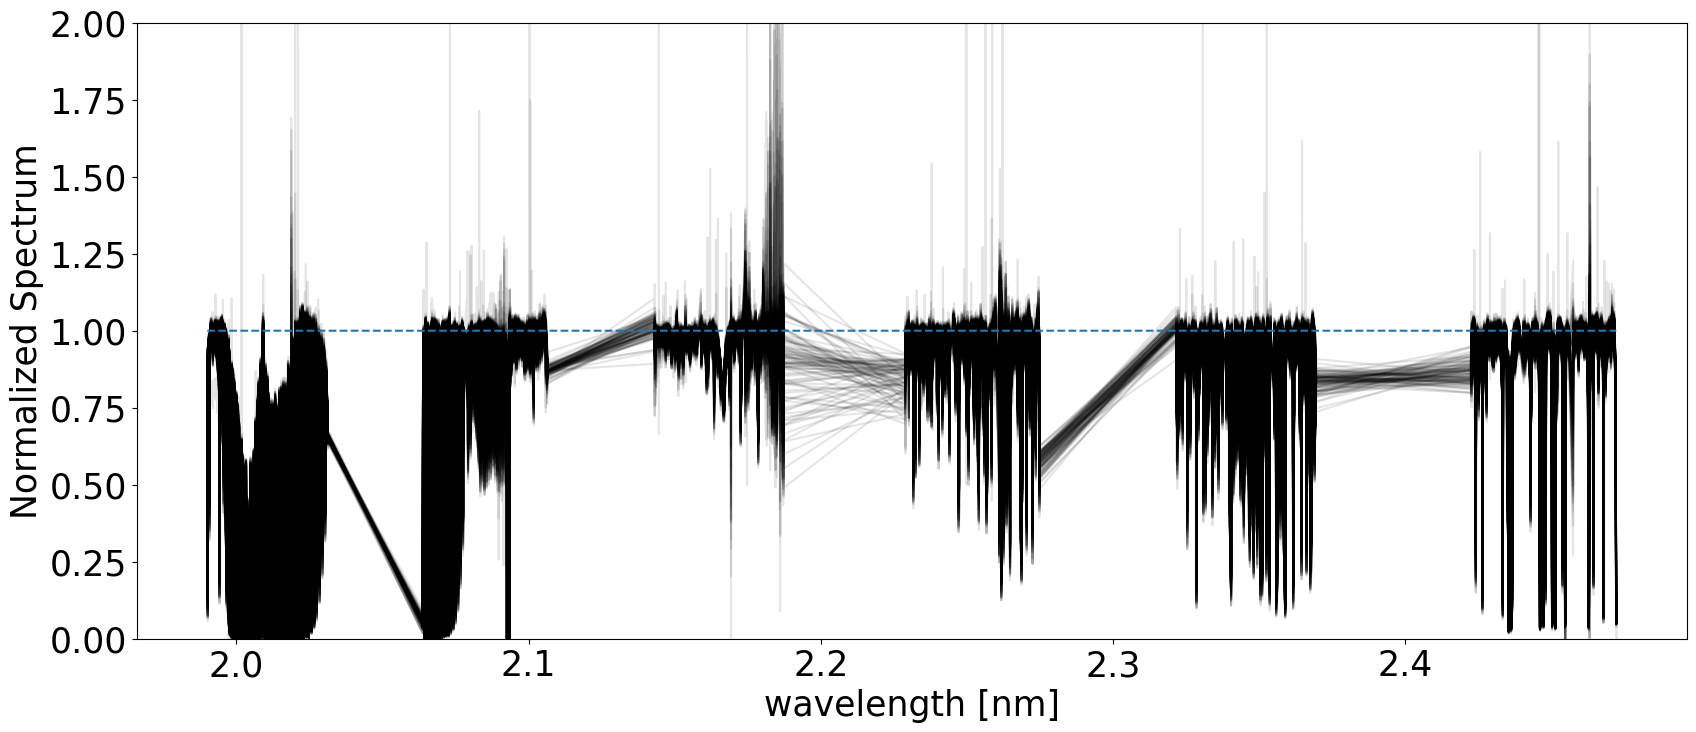

In [83]:
for i in range(len(all_observation_full_wave_n)):
    plt.plot(all_observation_full_wave_n[i]/1000, all_observation_full_flux_n[i] ,color = 'k', alpha=0.1)

plt.plot(all_observation_full_wave_n[0]/1000, np.ones_like(all_observation_full_wave_n[0]), '--')

plt.ylim(0,2)
plt.ylabel(r"Normalized Spectrum")
plt.xlabel(r"wavelength [nm]")

In [84]:
# Master Spectrum

In [96]:
master_spectrum = np.median(all_observation_full_wave_n, axis=0)
master_flux = np.median(all_observation_full_flux_n, axis=0)

In [97]:
print(master_spectrum)

[1990.00205961 1990.00890192 1990.0157441  ... 2472.19527126 2472.20247352
 2472.20967559]


(0.0, 1.1)

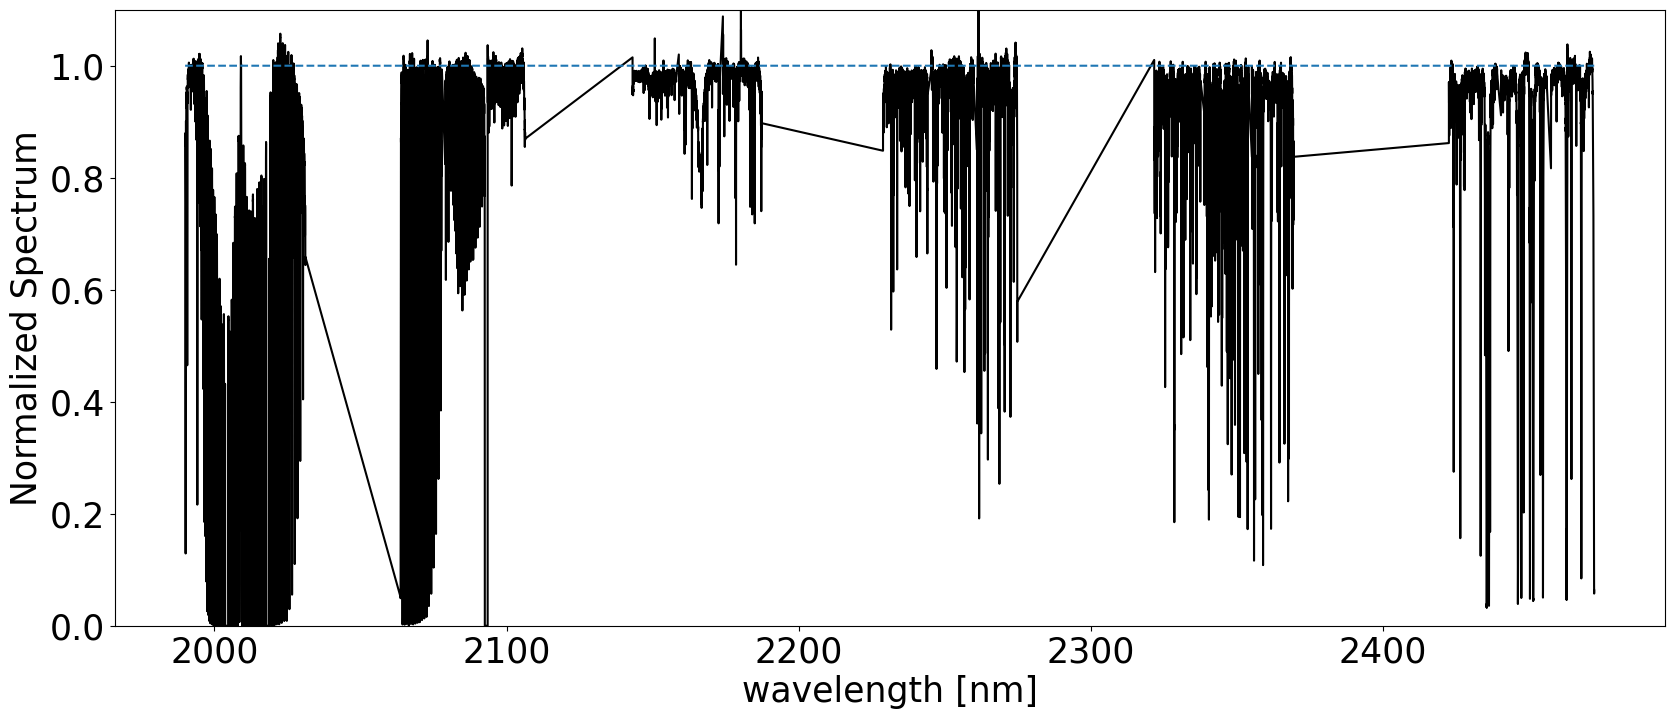

In [98]:
plt.plot(master_spectrum, master_flux, 'k')
plt.plot(all_observation_full_wave_n[0], np.ones_like(all_observation_full_wave_n[0]), '--')

plt.ylabel(r"Normalized Spectrum")
plt.xlabel(r"wavelength [nm]")

plt.ylim(0,1.1)

(0.0, 1.1)

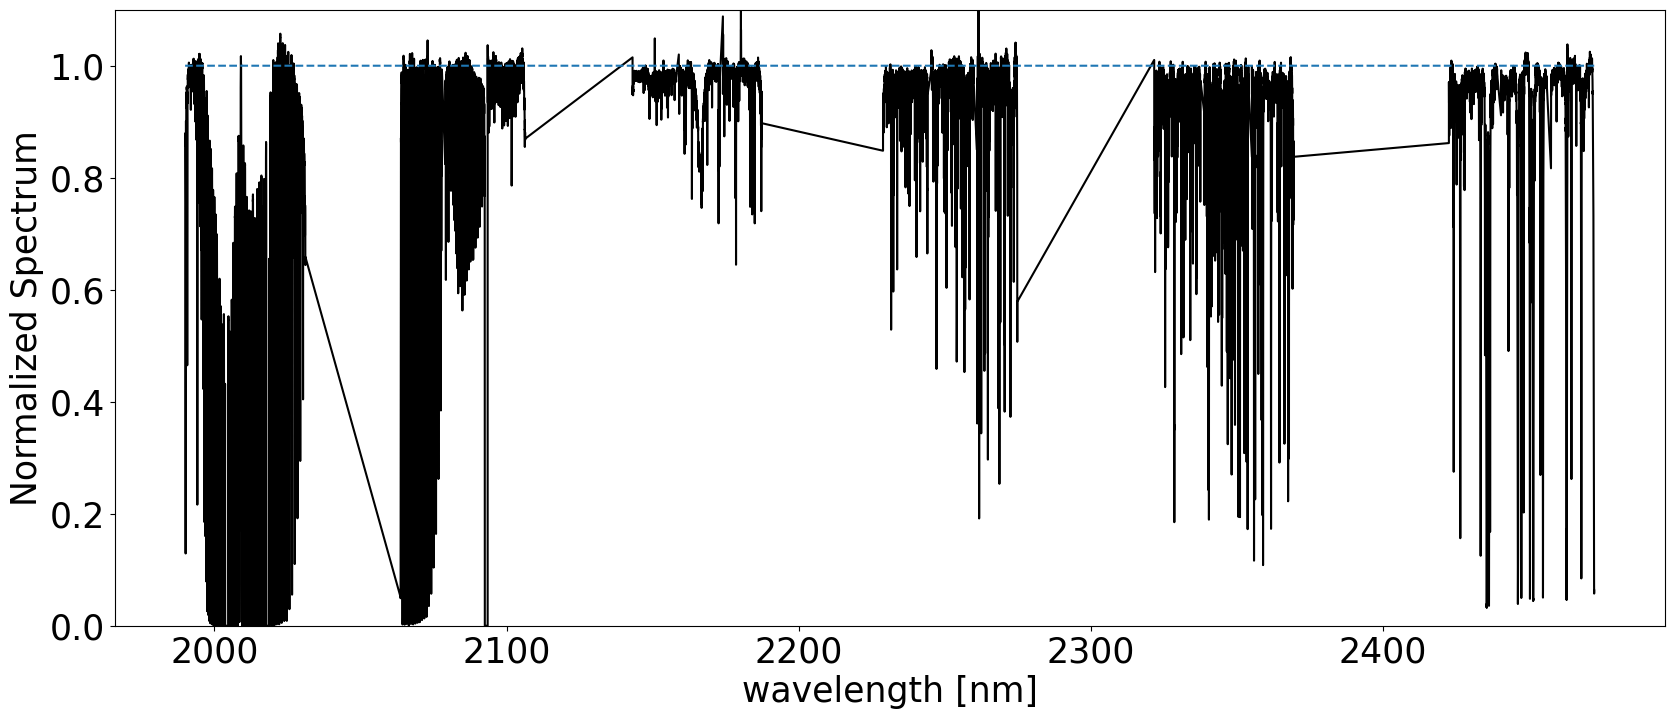

In [101]:
plt.plot(master_spectrum, master_flux, 'k')
plt.plot(all_observation_full_wave_n[0], np.ones_like(all_observation_full_wave_n[0]), '--')

plt.ylabel(r"Normalized Spectrum")
plt.xlabel(r"wavelength [nm]")

#plt.xlim(1950,2600)
plt.ylim(0,1.1)

In [104]:
transit_flux = np.median(all_observation_full_flux_n[60:90], axis=0)

In [124]:
transmission = 1- transit_flux/master_flux

/var/folders/rb/x7czqcn50038tc9lzxkw7z4h0000gn/T/ipykernel_9783/3096306613.py:1: RuntimeWarning: invalid value encountered in true_divide
  transmission = 1- transit_flux/master_flux


(-0.5, 0.5)

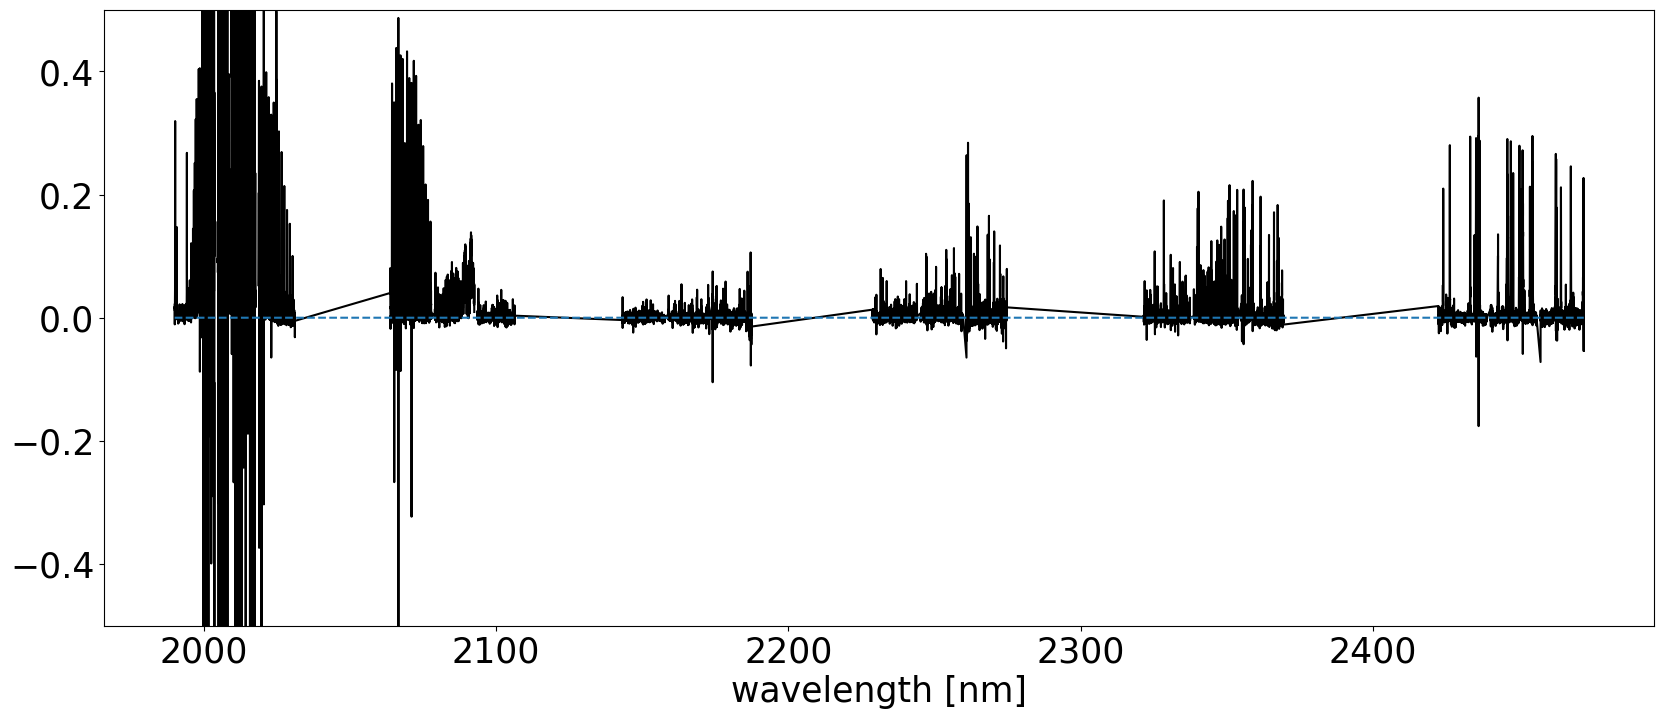

In [125]:
plt.plot(master_spectrum, transmission, 'k')
plt.plot(all_observation_full_wave_n[0], np.zeros_like(all_observation_full_wave_n[0]), '--')

#plt.ylabel(r"Normalized Spectrum")
plt.xlabel(r"wavelength [nm]")

#plt.xlim(1950,2600)
plt.ylim(-0.5,0.5)

In [126]:
#from statsmodels import robust
#@jit
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

#@jit
def bining_data(data, factor):
    "bining the function by a factor"
    size = len(data)
    data_left = size%factor
    if data_left != 0:
        size_data_bin = int(size/factor) + 1
    else:
        size_data_bin = int(size/factor) + 0
        
    data_bin = np.zeros(size_data_bin)
    data_error = np.zeros(size_data_bin)
    for i, element in enumerate(data_bin):
        #data_bin[i] = np.median(data[i*factor:(i+1)*factor])
        #data_error[i] = mad(data[i*factor:(i+1)*factor])
        data_bin[i] = np.mean(data[i*factor:(i+1)*factor])
        data_error[i] = np.std(data[i*factor:(i+1)*factor])
    return data_bin, data_error

In [152]:
factor_bining =4100
lambda_b, err = bining_data(master_spectrum, factor_bining)
ratio_b,  err = bining_data(transmission, factor_bining)

(0.0, 15000.0)

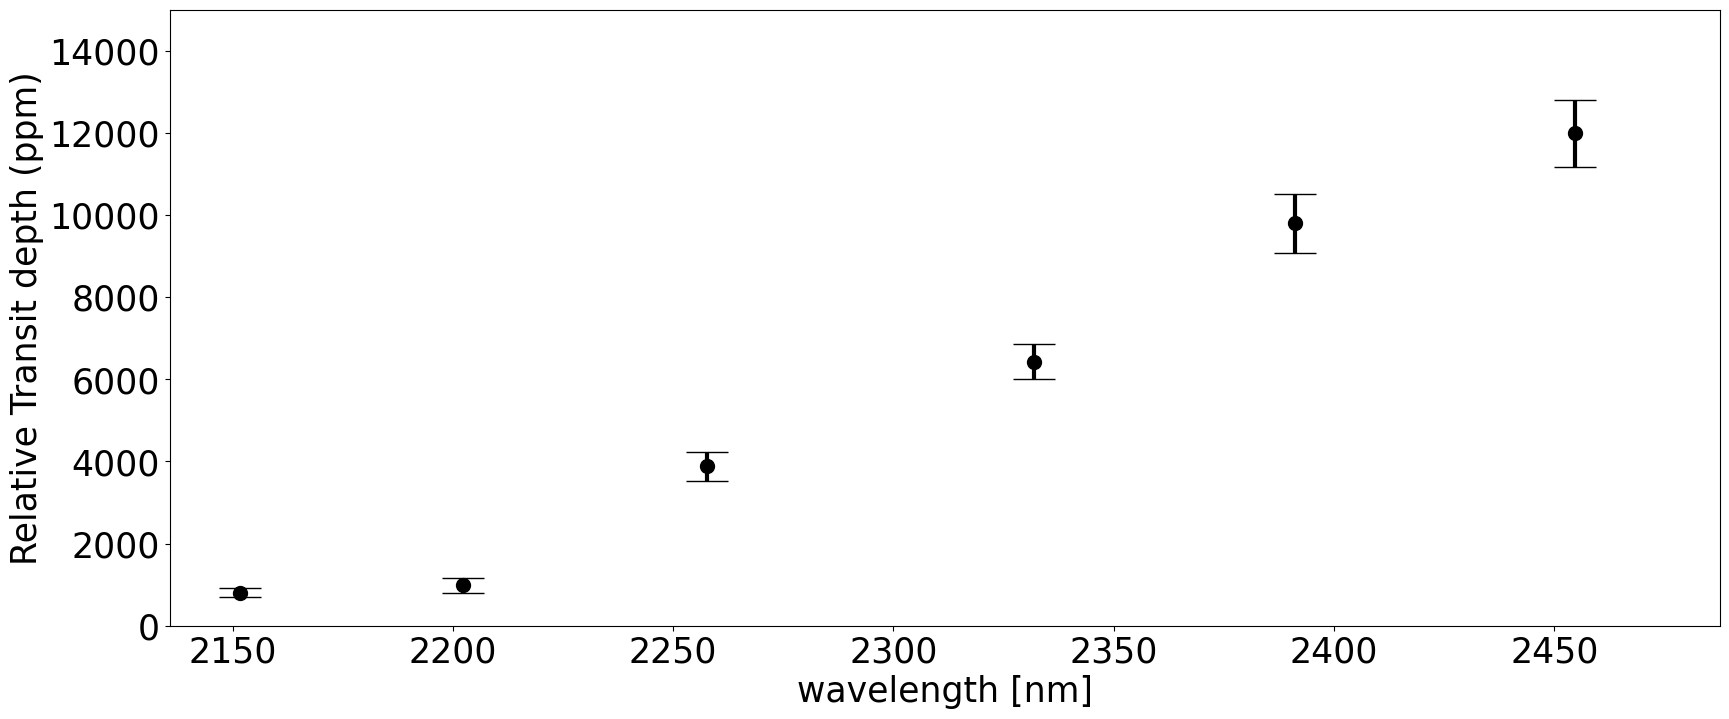

In [158]:
A = 1E6
plt.errorbar(lambda_b, ratio_b*A, yerr=err/np.sqrt(factor_bining/3)*A, fmt='o', color='k', capsize=15 ,
             markersize=10, elinewidth=3)

plt.ylabel(r"Relative Transit depth (ppm)")
plt.xlabel(r"wavelength [nm]")
plt.ylim(0,15000)